# How to automatically find detectors?

This notebook show in a simple example how automatic detector computation is performed.

## Build the quantum circuit

In most cases, your QEC implementation will be encoded in a quantum circuit structure. Due to its omnipresence in QEC-related tasks, `stim.Circuit` is the quantum circuit representation that is expected by the package.

Note that the quantum circuit does not have to represent a complete error-corrected computation. In particular, you might want to use knowledge about the quantum error-correction code used to only submit a sub-circuit of the whole computation. For example, if you know that you code is local and that detectors will only include measurements close to each other, it might be interesting to only compute the detectors on a small sub-circuit and re-use the computed detectors on a larger circuit. 

For the purposes of demonstration, we will use a repetition code of distance `3`, performing memory operations for `10` rounds.

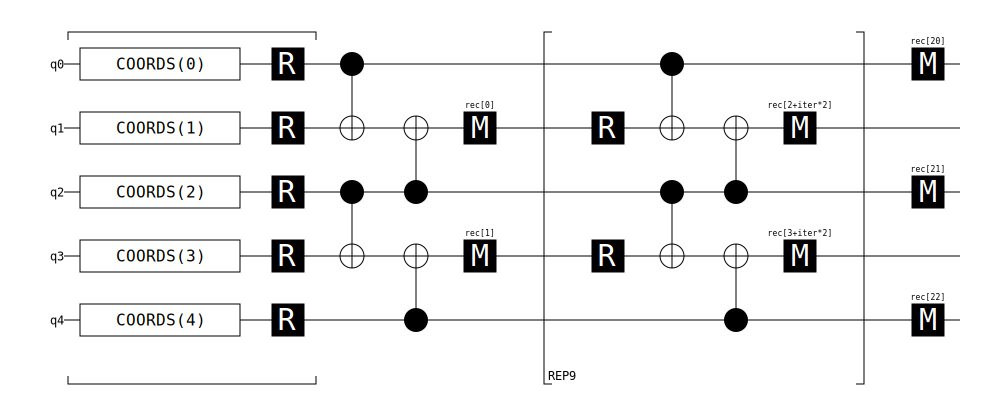

In [1]:
import stim

circuit = stim.Circuit("""
QUBIT_COORDS(0) 0
QUBIT_COORDS(1) 1
QUBIT_COORDS(2) 2
QUBIT_COORDS(3) 3
QUBIT_COORDS(4) 4
R 0 1 2 3 4
TICK
CX 0 1 2 3
TICK
CX 2 1 4 3
TICK
M 1 3
TICK
REPEAT 9 {
    R 1 3
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    M 1 3
    TICK
}
M 0 2 4""")
circuit.diagram("timeline-svg")

Note that the quantum circuit generated by `stim.Circuit.generated` includes a few structures that are not supported by the package. As such, you should ensure that the circuits provided are checking a few pre-conditions. 

That is one of the reasons why the circuit is explicitly provided above and not directly generated with a call to `stim.Circuit.generated`.

## Split the quantum circuit

Once the quantum circuit is built and adhere to the pre-conditions imposed by the package, we need to split that circuit into a sequence of fragments. 

In [2]:
from tqec.circuit.detectors.fragment import split_stim_circuit_into_fragments

fragments = split_stim_circuit_into_fragments(circuit)

We can explore the fragments built:

In [3]:
for fragment in fragments:
    print("=" * 80)
    print(fragment)

Fragment(circuit=stim.Circuit('''
    QUBIT_COORDS(0) 0
    QUBIT_COORDS(1) 1
    QUBIT_COORDS(2) 2
    QUBIT_COORDS(3) 3
    QUBIT_COORDS(4) 4
    R 0 1 2 3 4
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    M 1 3
    TICK
'''))
FragmentLoop(repetitions=9, fragments=[Fragment(circuit=stim.Circuit('''
    R 1 3
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    M 1 3
    TICK
'''))])
Fragment(circuit=stim.Circuit('''
    M 0 2 4
'''))


## Pre-computing flows

Now that the quantum circuit is adequately split into fragments, we can start pre-computing the flows for each fragment. 

For the moment, the package is limited to detectors that only include measurements from `2` fragments: the current one and the one before. Due to that limitation, we do not have to compute any "propagation" flow: only "creation" and "destruction" flows are needed to find such detectors.

In [4]:
from tqec.circuit.detectors.flow import build_flows_from_fragments

flows = build_flows_from_fragments(fragments)

Just like fragments, it is interesting to explore and visualise the different flows computed.

In [5]:
for flow in flows:
    print("=" * 80)
    print("Flow(")
    print("  creation = [")
    for creation in flow.creation:
        print(f"    {creation}")
    print("  ],")
    print("  destruction = [")
    for destruction in flow.destruction:
        print(f"    {destruction}")
    print("  ],")
    print(f"total_number_of_measurements = {flow.total_number_of_measurements}")
    print(")")

Flow(
  creation = [
    BoundaryStabilizers(stabilizer=Z0, collapsing_operations=[Z3, Z1], measurements=[], resets={0}, is_forward=True)
    BoundaryStabilizers(stabilizer=Z0*Z1*Z2, collapsing_operations=[Z3, Z1], measurements=[RelativeMeasurementLocation(offset=-2, qubit_index=1)], resets={1}, is_forward=True)
    BoundaryStabilizers(stabilizer=Z2, collapsing_operations=[Z3, Z1], measurements=[], resets={2}, is_forward=True)
    BoundaryStabilizers(stabilizer=Z2*Z3*Z4, collapsing_operations=[Z3, Z1], measurements=[RelativeMeasurementLocation(offset=-1, qubit_index=3)], resets={3}, is_forward=True)
    BoundaryStabilizers(stabilizer=Z4, collapsing_operations=[Z3, Z1], measurements=[], resets={4}, is_forward=True)
  ],
  destruction = [
    BoundaryStabilizers(stabilizer=Z0*Z1*Z2, collapsing_operations=[Z2, Z4, Z0, Z1, Z3], measurements=[RelativeMeasurementLocation(offset=-2, qubit_index=1)], resets={0, 1, 2}, is_forward=False)
    BoundaryStabilizers(stabilizer=Z2*Z3*Z4, collapsing_op

Let's use the first fragment and its associated flows as an example and illustrate using [Crumble](https://algassert.com/crumble), a nice tool that can be used to explore stabilizer propagation.

The first "creation" stabilizer is

```
BoundaryStabilizers(
    stabilizer=Z0, 
    collapsing_operations=[Z3, Z1], 
    involved_measurements=[],
    source_qubits={0}
)
```

which originate from the propagation described below:

In [6]:
from IPython.display import IFrame

IFrame(
    "https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(4,0)4;R_0_1_2_3_4;MARKZ(0)0;TICK;CX_0_1_2_3;TICK;CX_2_1_4_3;TICK;M_1_3",
    "100%",
    350,
)

A more interesting propagation is the second "creation" boundary stabilizer:

```
BoundaryStabilizers(
    stabilizer=Z0*Z1*Z2, 
    collapsing_operations=[Z3, Z1], 
    involved_measurements=[RelativeMeasurementLocation(offset=-2, qubit_index=1)],
    source_qubits={1}
)
```

resulting from the propagation:

In [7]:
from IPython.display import IFrame

IFrame(
    "https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(4,0)4;R_0_1_2_3_4;MARKZ(0)1;TICK;CX_0_1_2_3;TICK;CX_2_1_4_3;TICK;M_1_3;MARKZ(0)1",
    "100%",
    350,
)

Note that the `BoundaryStabilizer` stores the state of the stabilizer propagation **before** any non-reversible collapsing operations. That way, from a `BoundaryStabilizer` instance, you have a direct access to the stabilizer resulting from the propagation before any collapsing operation and you can compute the stabilizer obtained after the collapsing operations.

Let's take one last example, but this time the "destruction" flow
```
BoundaryStabilizers(
    stabilizer=Z0*Z1*Z2,
    collapsing_operations=[Z1, Z3, Z2, Z4, Z0], 
    involved_measurements=[RelativeMeasurementLocation(offset=-2, qubit_index=1)],
    source_qubits={1}
)
```
that can be visualised below:

In [8]:
from IPython.display import IFrame

IFrame(
    "https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(4,0)4;R_0_1_2_3_4;MARKZ(0)0_1_2;TICK;CX_0_1_2_3;TICK;CX_2_1_4_3;TICK;M_1_3;MARKZ(0)1",
    "100%",
    350,
)

In this step, we pre-computed the necessary information to find detectors: creation and destruction flows. The next step is to use that information to try to find detectors.

## Finding detectors

The problem of finding a detector can be rephrased as finding one or more flow(s) that, when considered together, do not propagate and are fully collapsed by collapsing operations.

The destruction flow visualised above is a good example: it is generated by the measurement on the second qubit, back-propagates in the fragment, and end up on 3 reset instructions that collapse entirely the flow. This means that all the measurements touched by that flow (i.e., for that example, the measurement on the second qubit) form a detector.

The package has an iterative approach to find detectors:

1. Try to find detectors fully contained within a single flow (the example of a destruction flow above is exactly in this case).
2. For each adjacent flows `f1 -- f2`, try to find detectors spanning across these two flows:
    1. First by trying to match `1` creation flow from `f1` to `1` destruction flow from `f2`.
    2. Then by trying to find:
        - `n > 1` creation flows from `f1` that, when combined, match with `1` destruction flow from `f2`.
        - `1` creation flow from `f1` that match with `n > 1` destruction flows from `f2` when combined.

The above methodology is only applied on flows that commute with their collapsing operations. For example, the flow

In [9]:
from IPython.display import IFrame

IFrame(
    "https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(4,0)4;R_0_1_2_3_4;MARKZ(0)1;TICK;CX_0_1_2_3;TICK;CX_2_1_4_3;TICK;H_1;TICK;M_1_3;MARKZ(0)1",
    "100%",
    350,
)

does not commute with its collapsing operation (the measurement). This can be seen quite easily from the `BoundaryStabilizer` instance that would represent this flow:

```
BoundaryStabilizers(
    stabilizer=Z0*X1*Z2, 
    collapsing_operations=[Z3, Z1], 
    involved_measurements=[RelativeMeasurementLocation(offset=-2, qubit_index=1)],
    source_qubits={1}
)
```

The stabilizer `Z0*X1*Z2` does not commute with the collapsing operation `Z1`.

In such cases, there is an intermediary step `1.5` that consist in try to merge several anti-commuting flows together to form new commuting flows.

Coming back to the code, detectors can be listed by calling `match_detectors_from_flows_shallow`:

In [10]:
from tqec.circuit.detectors.match import match_detectors_from_flows_shallow

qubit_coordinates = {
    q: tuple(coords) for q, coords in circuit.get_final_qubit_coordinates().items()
}
matched_detectors = match_detectors_from_flows_shallow(flows, qubit_coordinates)

This function will return, for each of the provided flows, a list of detectors:

In [11]:
for i, detectors in enumerate(matched_detectors):
    print(f"Detectors found for fragment number {i}:")
    for detector in detectors:
        print("  ", detector.to_instruction())

Detectors found for fragment number 0:
   DETECTOR(3, 0) rec[-1]
   DETECTOR(1, 0) rec[-2]
Detectors found for fragment number 1:
   DETECTOR(1, 0) rec[-2] rec[-4]
   DETECTOR(3, 0) rec[-1] rec[-3]
Detectors found for fragment number 2:
   DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
   DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]


## Wrapping up

In the previous sections, you have seen the process used to compute detectors. In practice, this process is long and tedious to write, so a function performing all the above steps and constructing an equivalent quantum circuit with the computed detectors has been included in the package: `annotate_detectors_automatically`.

One example of its usage is available below.

In [12]:
from tqec.circuit.detectors.construction import annotate_detectors_automatically
from tqec.circuit.detectors.utils import remove_annotations

print(remove_annotations(circuit))
annotated_circuit = annotate_detectors_automatically(remove_annotations(circuit))

QUBIT_COORDS(0) 0
QUBIT_COORDS(1) 1
QUBIT_COORDS(2) 2
QUBIT_COORDS(3) 3
QUBIT_COORDS(4) 4
R 0 1 2 3 4
TICK
CX 0 1 2 3
TICK
CX 2 1 4 3
TICK
M 1 3
TICK
REPEAT 9 {
    R 1 3
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    M 1 3
    TICK
}
M 0 2 4


QUBIT_COORDS(0) 0
QUBIT_COORDS(1) 1
QUBIT_COORDS(2) 2
QUBIT_COORDS(3) 3
QUBIT_COORDS(4) 4
R 0 1 2 3 4
TICK
CX 0 1 2 3
TICK
CX 2 1 4 3
TICK
M 1 3
DETECTOR(3, 0) rec[-1]
DETECTOR(1, 0) rec[-2]
TICK
REPEAT 9 {
    R 1 3
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    M 1 3
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-4]
    DETECTOR(3, 0) rec[-1] rec[-3]
    TICK
}
M 0 2 4
DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]


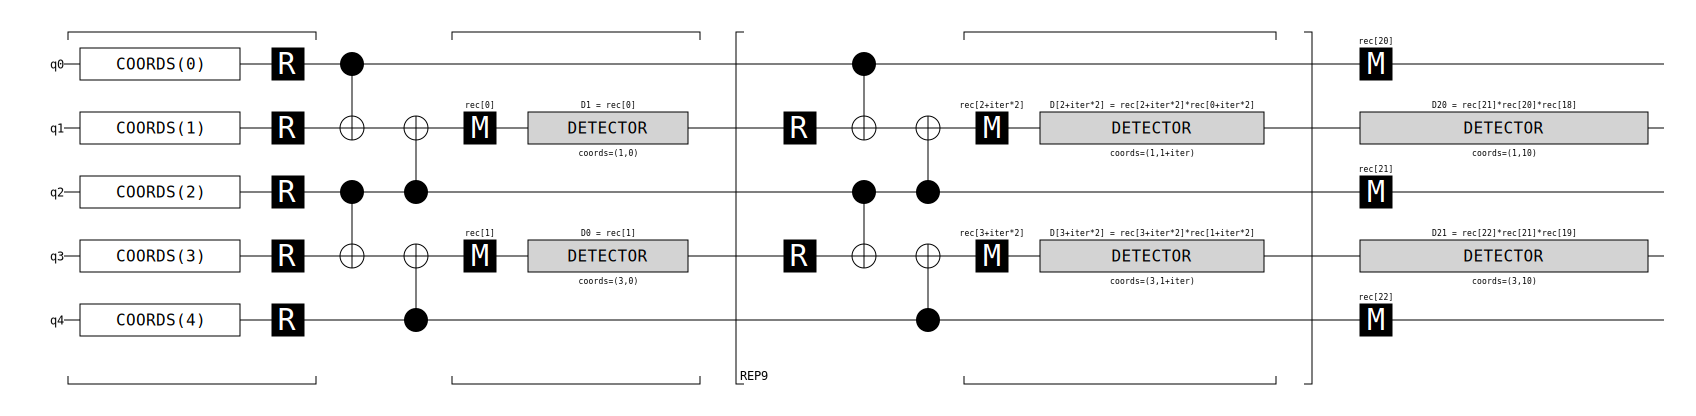

In [13]:
print(annotated_circuit)
annotated_circuit.diagram("timeline-svg")